In [1]:
import numpy as np
import pandas as pd

import scipy as sp
import scipy.cluster

import itertools
import string
import pickle
import glob
import os
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from crosspy.core.autocorrelation import get_length_by_cdf, transform_to_cdf

from utils.stats import bootstrap_statistic
from utils.fooof_utils import get_foofed_spectrum, get_foof_model
from utils.colors import okabe, CB_color_cycle, ripples_blue, noise_color, ripples_orange
from utils.io import *
from utils.pyutils import convert_to_array

from joblib import Parallel, delayed

import tqdm

import mne
import re

import seaborn as sns

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
%config InlineBackend.figure_format = 'jpg'

In [3]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)
sp.cluster.hierarchy.set_link_color_palette(CB_color_cycle)

In [4]:
submission_data_path = r'L:\nttk-data3\palva\Vlad\meso_submission_data'

In [10]:
meta_data_fpath = os.path.join(submission_data_path, 'SEEG', 'meta_data_subjects.pickle')
meta_data_subjects = pickle.load(open(meta_data_fpath, 'rb'))

res_path = os.path.join(submission_data_path, 'SEEG', 'pac_signal_frequency', 'pac_sub*.pickle')
res_files = glob.glob(res_path)
print(len(res_files))

68


In [11]:
lags_cycles = np.arange(200)/10

bad_subjects = ('02', '40', '06', '42', '60', '57', '18')

In [12]:
cohort_pacf_lifetime = list()
noise_pacf_lifetime = list()

subj_nums = list()
cohort_locations = list()
cohort_ez_chans = list()
data_parcels = list()

for fname in res_files:
    base_name = os.path.split(fname)[~0]
    subj_num = re.findall(r'\d+', base_name)[0]
    
    subj_montage = meta_data_subjects[subj_num]['montage']
    subj_montage = subj_montage[subj_montage['name'].apply(is_bipolar)]
    subj_chans = subj_montage['name'].tolist()
    
    subj_elecs = meta_data_subjects[subj_num]['electrodes']

    subj_mop =  meta_data_subjects[subj_num]['mop']
    subj_parcels = subj_mop['parcel_assign']
    
    subj_res = pickle.load(open(fname, 'rb'))
    
    if subj_res['data_pac'].shape[1] != subj_montage.shape[0] or (subj_num in bad_subjects):
        print('passing', subj_num)
        continue
        
    if np.array_equal(subj_chans, subj_mop['channel_names']) == False:
        index_mapper = [subj_chans.index(n) for n in subj_mop['channel_names']]
        subj_parcels = subj_parcels[index_mapper]
    
    sources = [v.split('-')[0] for v in subj_montage['name']]
    elec_locations = np.array([subj_elecs.loc[ch][['x', 'y', 'z']].values for ch in sources])
    
    subj_lengths_channelwise = np.array([np.apply_along_axis(lambda arr: get_length_by_cdf(arr, lags_cycles, 0.9), 1, pac)
                    for pac in subj_res['data_pac']])
    
    subj_noise_lengths_channelwise = np.array([np.apply_along_axis(lambda arr: get_length_by_cdf(arr, lags_cycles, 0.9), 1, pac) 
                     for pac in subj_res['noise_pac']])

    cohort_pacf_lifetime.append(subj_lengths_channelwise)
    noise_pacf_lifetime.append(subj_noise_lengths_channelwise)
    subj_nums.append(subj_num)
    cohort_locations.append(elec_locations)
    data_parcels.append(subj_parcels)
    
f_vals = np.array(subj_res['f_vals'])

cohort_pacf_lifetime = convert_to_array(cohort_pacf_lifetime)
noise_pacf_lifetime = convert_to_array(noise_pacf_lifetime)

passing 02
passing 06


d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\crosspy-0.0.1b0-py3.7.egg\crosspy\core\autocorrelation.py:27: RuntimeWarning: invalid value encountered in true_divide


passing 18
passing 19
passing 40
passing 42
passing 57
passing 60


In [14]:
real_sub = '10'
subj_fpath = os.path.join(submission_data_path, 'SEEG', 'pac_signal_frequency', f'pac_sub-{real_sub}.pickle')

sidx = [idx for idx, fname in enumerate(subj_nums) if real_sub in fname][0]
example_pac = pickle.load(open(subj_fpath, 'rb'))

In [15]:
all_noise_lengths = np.concatenate(noise_pacf_lifetime, axis=-1)

noise_level = np.percentile(all_noise_lengths, 99, axis=-1)
noise_mean = np.mean(all_noise_lengths, axis=-1)

In [16]:
fidx = 16*2

long_pac_idx = (cohort_pacf_lifetime[sidx][fidx] >= 5)

data_avg_pac = example_pac['data_pac'][fidx].mean(axis=0)
data_std_pac = example_pac['data_pac'][fidx].std(axis=0)

long_avg_pac = example_pac['data_pac'][fidx][long_pac_idx].mean(axis=0)
short_avg_pac = example_pac['data_pac'][fidx][~long_pac_idx].mean(axis=0)

pac_percentile_25, pac_percentile_75 = np.percentile(example_pac['data_pac'][fidx], (25,75), axis=0)

long_percentile_25, long_percentile_75 = np.percentile(example_pac['data_pac'][fidx][long_pac_idx], (25,75), axis=0)
short_percentile_25, short_percentile_75 = np.percentile(example_pac['data_pac'][fidx][~long_pac_idx], (25,75), axis=0)

noise_avg_pac = example_pac['noise_pac'][fidx].mean(axis=0)
noise_std_pac = example_pac['noise_pac'][fidx].std(axis=0)

data_pac_cdfs = np.apply_along_axis(transform_to_cdf, 1, example_pac['data_pac'][fidx])
noise_pac_cdfs = np.apply_along_axis(transform_to_cdf, 1, example_pac['noise_pac'][fidx])

cdf_avg = data_pac_cdfs.mean(axis=0)
cdf_std = data_pac_cdfs.std(axis=0)

noise_cdf_avg = noise_pac_cdfs.mean(axis=0)
noise_cdf_std = noise_pac_cdfs.std(axis=0)


### CDF

long_cdf_avg = data_pac_cdfs[long_pac_idx].mean(axis=0)
short_cdf_avg = data_pac_cdfs[~long_pac_idx].mean(axis=0)

long_cdf_p_25, long_cdf_p_75 = np.percentile(data_pac_cdfs[long_pac_idx], (5,95), axis=0)
short_cdf_p_25, short_cdf_p_75 = np.percentile(data_pac_cdfs[~long_pac_idx], (5,95), axis=0)

avg_pac_len = cohort_pacf_lifetime[sidx][fidx].mean()
std_pac_len = cohort_pacf_lifetime[sidx][fidx].std()

noise_avg_pac_len = noise_pacf_lifetime[sidx][fidx].mean()

# cohort_idxs = np.argsort(data_lengths.argmax(axis=1))

cdf_percentile_25, cdf_percentile_75 = np.percentile(data_pac_cdfs, (25,75), axis=0)

to_plot = cohort_pacf_lifetime[sidx]

In [17]:
fig_data_path = os.path.join(submission_data_path, 'figure_2', 'figure_psd_data.pickle')
fig_2_data = pickle.load(open(fig_data_path, 'rb'))
pxxf, subj_psds = fig_2_data['pxxf'], fig_2_data['subj_psds']

In [18]:
freq_mask = (pxxf >= 2) & (pxxf <= 48) | (pxxf >= 52) & (pxxf <= 98)
fooof_pxxf = pxxf[(pxxf >= 2) & (pxxf <= 98)]
spectrum_mask = pxxf[(pxxf >= 2) & (pxxf <= 98)]
spectrum_mask = ((spectrum_mask <= 48) | (spectrum_mask >= 52))

fooofed_spectrums = np.array(Parallel(n_jobs=32)(delayed(get_foofed_spectrum)(pxxf, spectrum) for spectrum in subj_psds))
fooofed_models = Parallel(n_jobs=32)(delayed(get_foof_model)(pxxf, spectrum) for spectrum in subj_psds)

foof_to_pac_idx = np.abs(fooof_pxxf.reshape(1,-1) - f_vals.reshape(-1,1)).argmin(axis=-1)


In [24]:
# foof_spectra_flat = np.array([mdl._spectrum_flat[foof_to_pac_idx] for mdl in fooofed_models])
foof_spectra_flat = np.array([mdl.fooofed_spectrum_[foof_to_pac_idx] for mdl in fooofed_models])
M_psds = sp.cluster.hierarchy.linkage(foof_spectra_flat, method='ward')

M_pacs = sp.cluster.hierarchy.linkage(to_plot.T, method='ward')

labels_pacs = sp.cluster.hierarchy.fcluster(M_pacs, t=4, criterion='maxclust') - 1

n_clusts = len(set(labels_pacs))

labels_pacs_ok = labels_pacs.copy()
labels_pacs_ok[labels_pacs == 2] = 1
labels_pacs_ok[labels_pacs == 1] = 2

labels_pacs = labels_pacs_ok.copy()

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


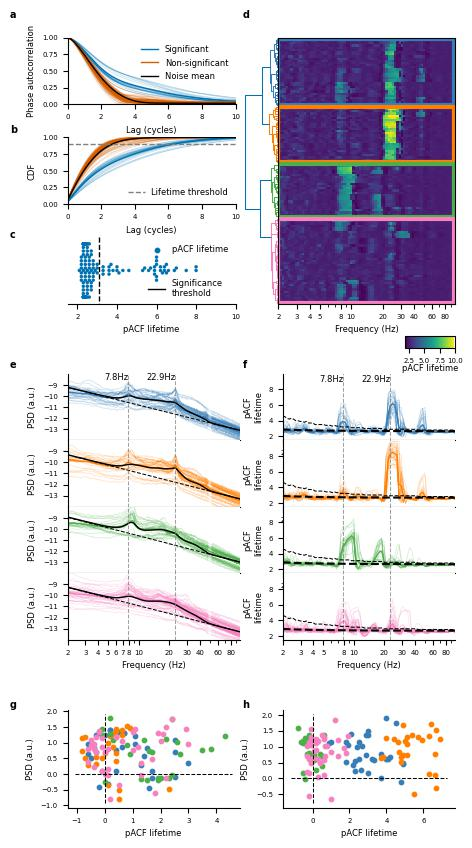

In [25]:
ts = np.arange(10000)/1000

nrows = 10
ncols = 9

fig = plt.figure(figsize=(5, 10))

gs_main = fig.add_gridspec(nrows, ncols, hspace=5)

gs1 = gs_main[:4, :4].subgridspec(3, 1, hspace=0.5, wspace=0.0)
gs2 = gs_main[:4, 4:].subgridspec(1, 2, wspace=0.0, width_ratios=[1,5])
gs3 = gs_main[4:8, :].subgridspec(4, 2, hspace=0.0, wspace=0.25)
gs4 = gs_main[8:, :].subgridspec(1, 2, wspace=0.25)

ax1 = fig.add_subplot(gs1[0])
ax9 = fig.add_subplot(gs1[1])
ax7 = fig.add_subplot(gs1[2])

ax10 = fig.add_subplot(gs2[0])
ax2 = fig.add_subplot(gs2[1])

ax11 = fig.add_subplot(gs4[0])
ax12 = fig.add_subplot(gs4[1])

axes_clusters = [fig.add_subplot(gs3[i, 1]) for i in range(n_clusts)]
axes_psd_clusters = [fig.add_subplot(gs3[i, 0]) for i in range(n_clusts)]

ax1.plot(lags_cycles, long_avg_pac, lw=1, color=ripples_blue, label='Significant')
ax1.plot(lags_cycles, example_pac['data_pac'][fidx][long_pac_idx].T, color=ripples_blue, lw=0.5, alpha=0.25)

ax1.plot(lags_cycles, short_avg_pac, lw=1, color=ripples_orange, label='Non-significant')
ax1.plot(lags_cycles, example_pac['data_pac'][fidx][~long_pac_idx].T, color=ripples_orange, lw=0.5, alpha=0.25)

ax1.plot(lags_cycles, noise_avg_pac, lw=1, color=noise_color, label='Noise mean')
sns.swarmplot(data=cohort_pacf_lifetime[sidx][fidx], orient='h', ax=ax7, color=ripples_blue, size=2.5, zorder=2)
ax7.plot([noise_level[fidx], noise_level[fidx]], [-0.5, 0.5], ls='--', color='black', lw=1, zorder=5)

ax7.scatter([50], [50], color=ripples_blue, s=10, label='pACF lifetime')
ax7.plot([50,50], [50,100], color='black', lw=1, label='Significance\nthreshold')

ax1.legend(fontsize=6, frameon=False)

ax9.plot(lags_cycles, short_cdf_avg, lw=1, color=ripples_orange)
ax9.plot(lags_cycles, data_pac_cdfs[~long_pac_idx].T, color=ripples_orange, lw=0.5, alpha=0.25)

ax9.plot(lags_cycles, long_cdf_avg, lw=1, color=ripples_blue)
ax9.plot(lags_cycles, data_pac_cdfs[long_pac_idx].T, color=ripples_blue, lw=0.5, alpha=0.25)

ax9.plot(lags_cycles, noise_cdf_avg, lw=1, color=noise_color)
ax9.plot([0, 25], [0.9, 0.9], ls='--', lw=1, color='gray', label='Lifetime threshold')

ax9.legend(fontsize=6, frameon=False)
with plt.rc_context({'lines.linewidth': 0.75}):
    dend_data = sp.cluster.hierarchy.dendrogram(M_pacs, color_threshold=30, ax = ax10, orientation='left', no_labels=True)

ax10.invert_yaxis()
ax2.set_xscale('log')

imh = ax2.pcolormesh(f_vals, np.arange(121), to_plot.T[dend_data['leaves']][::-1],  rasterized=True)

cax = fig.add_axes([0.8, 0.57, 0.1, 0.012])

cbar = fig.colorbar(imh, cax=cax, ax=ax2, orientation='horizontal')
cbar.ax.tick_params(labelsize=5) 
cax.set_xticks([2.5, 5, 7.5, 10.0])

cluster_sizes = np.cumsum([0] + [(labels_pacs == l).sum() for l in range(n_clusts)])

size_prev = 121
for idx, (ax, cluster_label, color, size, size_next) in enumerate(zip(axes_clusters, 
                                                     [0,2,1,3,4], 
                                                     itertools.cycle(okabe), 
                                                     cluster_sizes[:-1],
                                                     cluster_sizes[1:])):
    color = CB_color_cycle[idx]
    
    clust_idx = (labels_pacs == cluster_label)
    
    size = clust_idx.sum()
        
    avg_pac = to_plot[:, clust_idx].mean(axis=1)
    
    ax.semilogx(f_vals, to_plot[:, clust_idx], color=color, alpha=0.25, lw=0.5)
    ax.semilogx(f_vals, avg_pac, color=color, lw=1)
    
    ax.vlines([f_vals[28],f_vals[50]], 0, 15, ls='--', color='gray' ,lw=0.75, alpha=0.75)
    ax.semilogx(f_vals, noise_mean,  ls='--', color='black')
    ax.semilogx(f_vals, noise_level, ls='--', color='black', lw=0.75)

    ax.set_ylim([1.5, 10])
    
    size_prev -= size
    
    rect = patches.Rectangle([2, size_prev], 96, size-1,linewidth=3,edgecolor=color,facecolor='none')
    ax2.add_patch(rect)
        
    ax.set_ylabel('pACF\nlifetime', fontsize=6)
    
    if idx == 5:
        ax.set_xlabel('Frequency', fontsize=6)
        axes_psd_clusters[idx].set_xlabel('Frequency', fontsize=6)
        
    clust_ap_fit = np.array([fooofed_models[idx]._ap_fit for idx in np.where(clust_idx)[0]])
    clust_psd = np.array([fooofed_models[idx].power_spectrum for idx in np.where(clust_idx)[0]])
    clust_foof_models = np.array([fooofed_models[idx].fooofed_spectrum_ for idx in np.where(clust_idx)[0]])
    
    axes_psd_clusters[idx].semilogx(pxxf[freq_mask], clust_psd.mean(axis=0)[spectrum_mask], color=color, lw=1)
    axes_psd_clusters[idx].semilogx(pxxf[freq_mask], clust_psd[:, spectrum_mask].T, color=color, lw=0.5, alpha=0.25)
    axes_psd_clusters[idx].semilogx(pxxf[freq_mask], clust_ap_fit.mean(axis=0)[spectrum_mask], color='black', lw=0.75, ls='--')
    axes_psd_clusters[idx].semilogx(pxxf[freq_mask], clust_foof_models.mean(axis=0)[spectrum_mask], color='black', lw=1)
    
    axes_psd_clusters[idx].set_ylabel('PSD (a.u.)', fontsize=6)
    axes_psd_clusters[idx].vlines([f_vals[28],f_vals[50]], -15, -7, ls='--', color='gray', alpha=0.75, lw=0.75)
    axes_psd_clusters[idx].set_ylim([-14, -8])
    axes_psd_clusters[idx].set_yticks([-13,-12, -11, -10, -9])
    
    psd_freq_idx = np.abs(pxxf - f_vals[28]).argmin()
    ax11.scatter(to_plot[28, clust_idx] - noise_level[28], clust_psd[:, psd_freq_idx]- clust_ap_fit.mean(axis=0)[psd_freq_idx], s=10, color=color)
    
    if idx == 0:
        axes_psd_clusters[idx].text(pxxf[psd_freq_idx-32], -8.5, f'{round(f_vals[28], 1)}Hz', fontsize=6)
        ax.text(pxxf[psd_freq_idx-32], 9, f'{round(f_vals[28], 1)}Hz', fontsize=6)
    
    psd_freq_idx = np.abs(pxxf - f_vals[50]).argmin()
    ax12.scatter(to_plot[50, clust_idx] - noise_level[50], clust_psd[:, psd_freq_idx] - clust_ap_fit.mean(axis=0)[psd_freq_idx], color=color, s=10)
    
    if idx == 0:
        axes_psd_clusters[idx].text(pxxf[psd_freq_idx-110], -8.5, f'{round(f_vals[50], 1)}Hz', fontsize=6)
        ax.text(pxxf[psd_freq_idx-110], 9, f'{round(f_vals[50], 1)}Hz', fontsize=6)

for ax in [ax11, ax12]:
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    
    ax.hlines(0, *xl, color='black', ls='--', lw=0.75)
    ax.vlines(0, *yl, color='black', ls='--', lw=0.75)
        
    ax.set_xlabel('pACF lifetime', fontsize=6)
    ax.set_ylabel('PSD (a.u.)', fontsize=6)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for ax in axes_clusters + axes_psd_clusters + [ax2]:
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90]))
    ax.set_xticks([2,3,4,5,8,10,20,30,40,60,80])

    ax.set_xlim([f_vals[0], f_vals[~0]])

for ax in axes_clusters:
    ax.set_yticks([2,4,6,8])
    
cax.set_xlabel('pACF lifetime', fontsize=6, labelpad=0)
    
for ax in (axes_clusters + axes_psd_clusters + [ax1, ax9, ax7]):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax7.spines['left'].set_visible(False)
ax7.set_yticks([])

ax9.set_xlim([0,10])
ax9.set_ylim([0,1])
ax9.set_xlabel('Lag (cycles)', fontsize=6)
ax9.set_ylabel('CDF', fontsize=6)

ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)
ax10.spines['left'].set_visible(False)
ax10.spines['bottom'].set_visible(False)
ax10.set_xticks([])

for ax in axes_psd_clusters[:-1]:
    ax.set_xticks([])
    ax.set_xlim([f_vals[0], 98])

for ax in axes_psd_clusters[-1:] :
    ax.set_xticks([2,3,4,5,6,7,8,10,20,30,40,60,80])
    ax.set_xlim([f_vals[0], 98])

axes_psd_clusters[~0].set_xlabel('Frequency (Hz)', fontsize=6)
axes_clusters[~0].set_xlabel('Frequency (Hz)', fontsize=6)
    
# ax7.imshow(brain_img)   

ax1.set_xlim([0,10])
ax1.set_ylim([0,1])

ax1.set_ylabel('Phase autocorrelation', fontsize=6)
ax1.set_xlabel('Lag (cycles)', fontsize=6)

ax2.set_xlabel('Frequency (Hz)', fontsize=6)
ax2.set_yticks([])

ax7.set_xlim([1.5,10])
ax7.legend(fontsize=6, frameon=False, labelspacing=3.0)
ax7.set_xlabel('pACF lifetime', fontsize=6)

for ax in fig.get_axes():
    ax.tick_params(labelsize=5)

for label, ypos in zip('abceg', [0.9, 0.785, 0.68, 0.55, 0.21]):
    fig.text(0.01, ypos, label, fontsize=7, weight='bold')

for label, ypos in zip('dfh', [0.9, 0.55, 0.21]):
    fig.text(0.475, ypos, label, fontsize=7, weight='bold')
    
fig.tight_layout(h_pad=0.0)

# cax.set_ylabel('pACF lifetime')
fig.savefig('publication_figures/figure_2.png', dpi=300, bbox_inches="tight")

for format in ['svg', 'pdf']:
    fig.savefig(f'publication_figures_vector/figure_2.{format}', dpi=300, bbox_inches="tight")

In [26]:
psd_cost = M_psds[-10:,2][::-1]
pacf_cost = M_pacs[-10:,2][::-1]

psd_gain = psd_cost[:-1] - psd_cost[1:]
pacf_gain = pacf_cost[:-1] -pacf_cost[1:]

In [27]:
M_psds = sp.cluster.hierarchy.linkage(foof_spectra_flat, method='ward')
M_pacs = sp.cluster.hierarchy.linkage(to_plot.T, method='ward')

labels_psds = sp.cluster.hierarchy.fcluster(M_psds, t=4, criterion='maxclust') - 1
labels_pacs = sp.cluster.hierarchy.fcluster(M_pacs, t=4, criterion='maxclust') - 1

In [28]:
noise_gain = np.zeros((1000, 9))

for i in range(noise_gain.shape[0]):
    spectra_noise = foof_spectra_flat.copy()

    for j in range(spectra_noise.shape[0]):
        np.random.shuffle(spectra_noise[j])
        
    M_noise = sp.cluster.hierarchy.linkage(spectra_noise, method='ward')

    noise_cost = M_noise[-10:,2][::-1]
    noise_gain[i] = (noise_cost[:-1] - noise_cost[1:])/noise_cost[0]

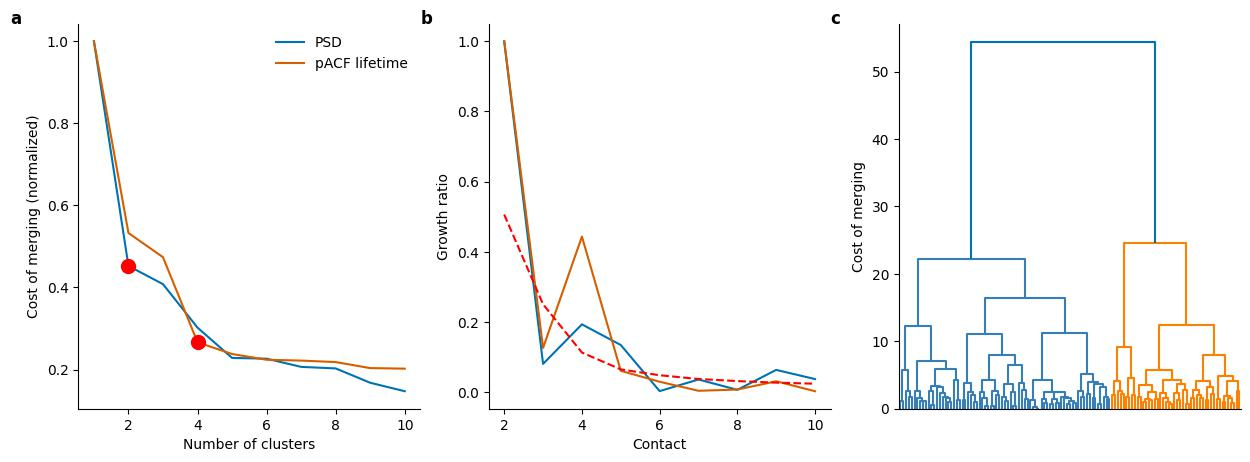

In [29]:
fig, axes = plt.subplots(figsize=(15,5), ncols=3)

axes[0].plot(np.arange(1,11), psd_cost/psd_cost[0], label='PSD')
axes[0].plot(np.arange(1,11), pacf_cost/pacf_cost[0], label='pACF lifetime')

axes[0].scatter([2],[psd_cost[1]/psd_cost[0]], color='red', s=100, zorder=5)
axes[0].scatter([4],[pacf_cost[3]/pacf_cost[0]], color='red', s=100, zorder=5)

axes[1].plot(range(2,11), psd_gain/psd_gain[0], label='PSD')
axes[1].plot(range(2,11), pacf_gain/pacf_gain[0], label='pACF lifetime')
axes[1].plot(range(2,11), np.percentile(noise_gain, q=99.5, axis=0), color='red', ls='--', label='Surrogate')

dend_data = sp.cluster.hierarchy.dendrogram(M_psds, no_labels=True, ax=axes[2])

axes[0].legend(fontsize=10, frameon=False)

axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Cost of merging (normalized)')

axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel('Growth ratio')

axes[2].set_ylabel('Cost of merging')
axes[1].set_xlabel('Contact')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
for ax, label in zip(axes, 'abc'):
    ax.text(-0.2, 1, label, transform=ax.transAxes, fontsize=12, weight='bold')
    
fig.savefig('publication_figures/figure_2_supp.png', dpi=300, bbox_inches="tight")